## 10.6 Lagged predictors
In cases where the impact of a predictor that is included in a regression model will not be simple and immediate. In these situations, we need to allow for lagged effects of the predictor. Suppose that we have only one predictor in our model. Then a model which allows for lagged effects can be written as
$$
y_t = \beta_0 + \gamma_0 x_t + \gamma_1x_{t-1} + \cdots + \gamma_k x_{t-k} + \eta_t,
$$
where $\eta_t$ is an ARIMA process. The value of $k$ can be selected using the AICc, along with the values of $p$ and $q$ for the ARIMA error.

### Example: TV advertising and insurance quotations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
from utils import *

In [3]:
df = rdatasets.data('fpp2', 'insurance')[['Quotes', 'TV.advert']]
df.columns = ['Quotes', 'TVadverts']
df = df.set_index(pd.date_range('2002-01-01', '2005-04-01', freq='MS'))

In [4]:
df_longer = pd.DataFrame(pd.concat([df.Quotes, df.TVadverts]), columns=['value'])
df_longer['var'] = 'Quotes'
df_longer['var'][len(df.Quotes):]  = 'TVadverts'

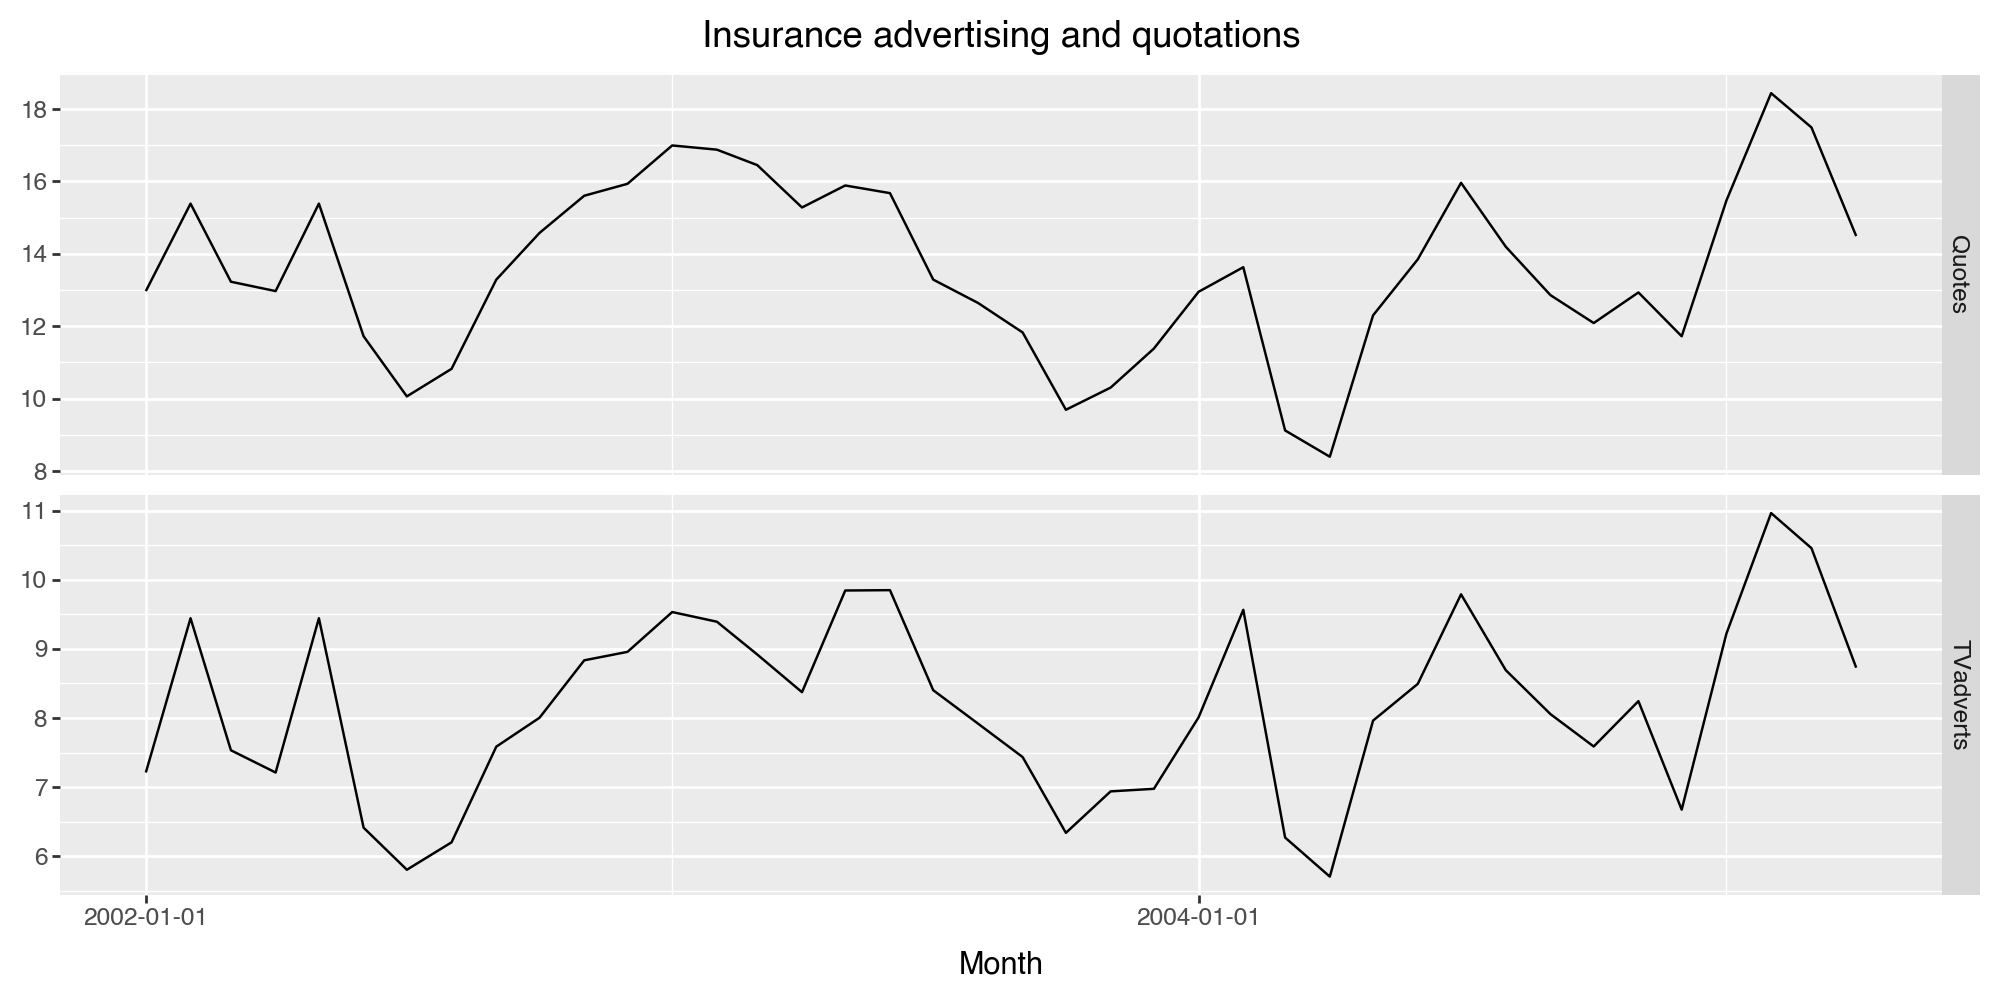

In [5]:
(
    ggplot(df_longer.reset_index())
    + aes(x="index", y="value")
    + geom_line()
    + facet_grid(rows="var", scales="free_y")
    + labs(x="Month", y="", title="Insurance advertising and quotations")
    + theme(figure_size=(10, 5))
)


In [6]:
for lag in range(4):
    df[f"advert_{lag}"] = df.TVadverts.shift(lag)

In [7]:
insurance = df.dropna()

In [1]:
import pmdarima as pm

In [11]:
df_train = insurance.iloc[:32]
df_test = insurance.iloc[32:]

In [12]:
%%time
lag0 = pm.auto_arima(
    df_train.Quotes, df_train['advert_0'.split()],
    d=0, suppress_warnings=True)
lag1 = pm.auto_arima(
    df_train.Quotes, df_train['advert_0 advert_1'.split()],
    d=0, suppress_warnings=True)
lag2 = pm.auto_arima(
    df_train.Quotes, df_train['advert_0 advert_1 advert_2'.split()],
    d=0, suppress_warnings=True)
lag3 = pm.auto_arima(
    df_train.Quotes, df_train['advert_0 advert_1 advert_2 advert_3'.split()],
    d=0, suppress_warnings=True)

CPU times: user 1.3 s, sys: 13.8 ms, total: 1.32 s
Wall time: 1.38 s


In [13]:
lags = lag0, lag1, lag2, lag3
lags


(ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True))

In [14]:
pd.DataFrame([dict(aic=l.aic(), aicc=l.aicc(), bic=l.bic(), fit=l) for l in (lags)])


,aic,aicc,bic,fit
0,59.052931,61.360623,66.381610,"ARIMA(1,0,1)(0,0,0)[0] intercept"
1,53.372556,55.680248,60.701235,"ARIMA(1,0,1)(0,0,0)[0]"
2,55.360453,58.720453,64.154868,"ARIMA(1,0,1)(0,0,0)[0]"
3,56.819785,63.080655,68.545672,"ARIMA(1,0,1)(0,0,0)[0] intercept"


In [15]:
fit = lag1.arima_res_
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -21.686
Date:                Tue, 26 Nov 2024   AIC                             53.373
Time:                        22:57:03   BIC                             60.701
Sample:                    04-01-2002   HQIC                            55.802
                         - 11-01-2004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
advert_0       1.3724      0.066     20.686      0.000       1.242       1.502
advert_1       0.2727      0.060      4.520      0.000       0.154       0.391
ar.L1          0.7035      0.201      3.508      0.000       0.310       1.097
ma.L1          0.6170      0.226      2.735      0.006       0.175       1.059
sigma2         0.2141      0.066      3.257      0.001       0.085       0.343
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                14.24
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.75   Skew:                            -1.26
Prob(H) (two-sided):                  0.11   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

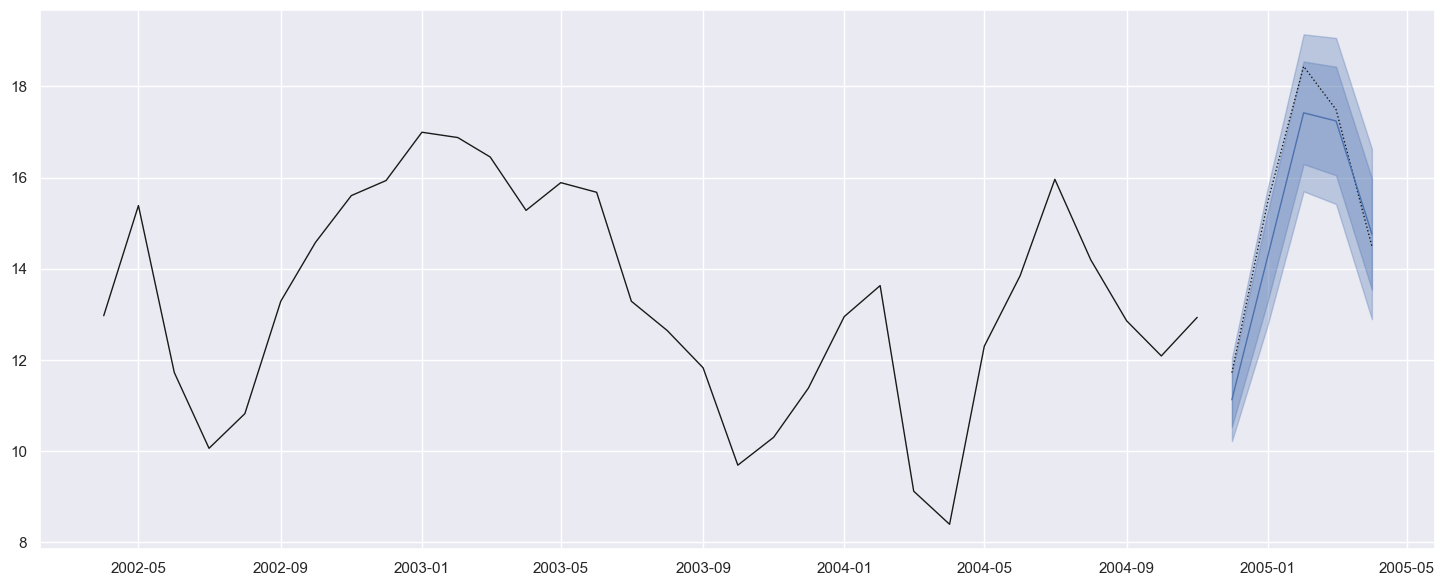

In [18]:
fig, ax = plt.subplots()
ax.plot(df_train.Quotes, 'k')
ax.plot(df_test.Quotes, 'k:')

fc = fit.get_forecast(
    len(df_test), exog=df_test['advert_0 advert_1'.split()])

ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
plt.show();

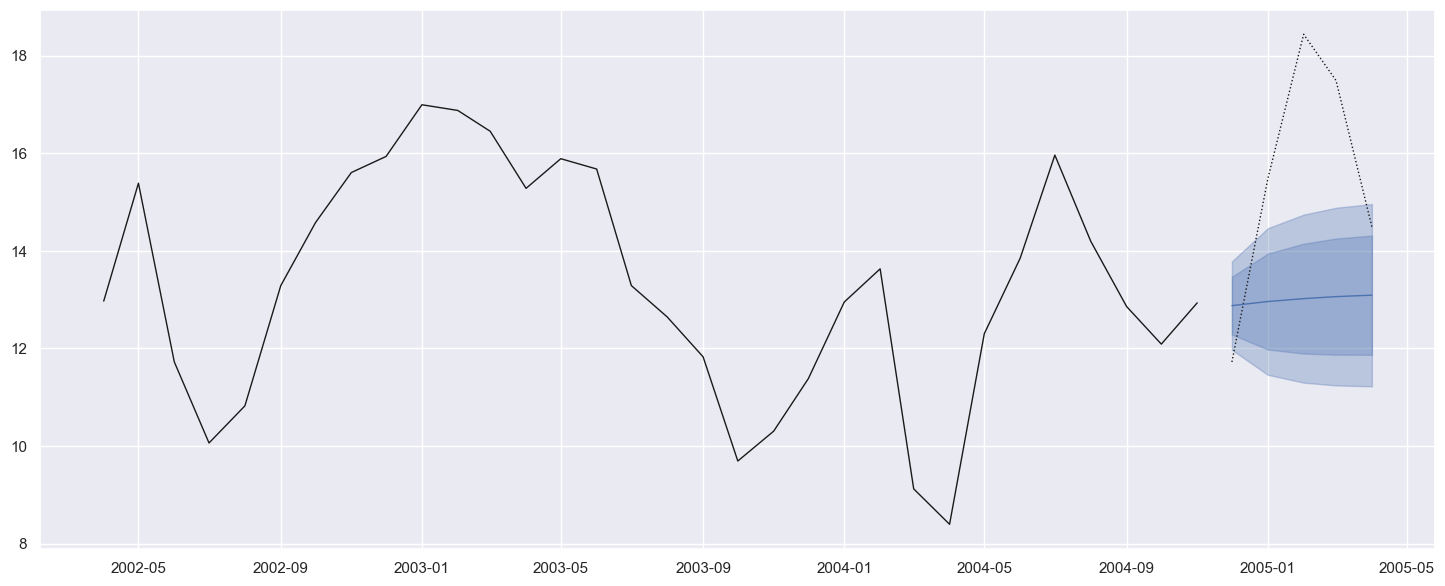

In [19]:
fig, ax = plt.subplots()
ax.plot(df_train.Quotes, 'k')
ax.plot(df_test.Quotes, 'k:')

fc = fit.get_forecast(
    len(df_test), exog=df_test.assign(advert_0=8, advert_1=8)['advert_0 advert_1'.split()])

ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
plt.show();